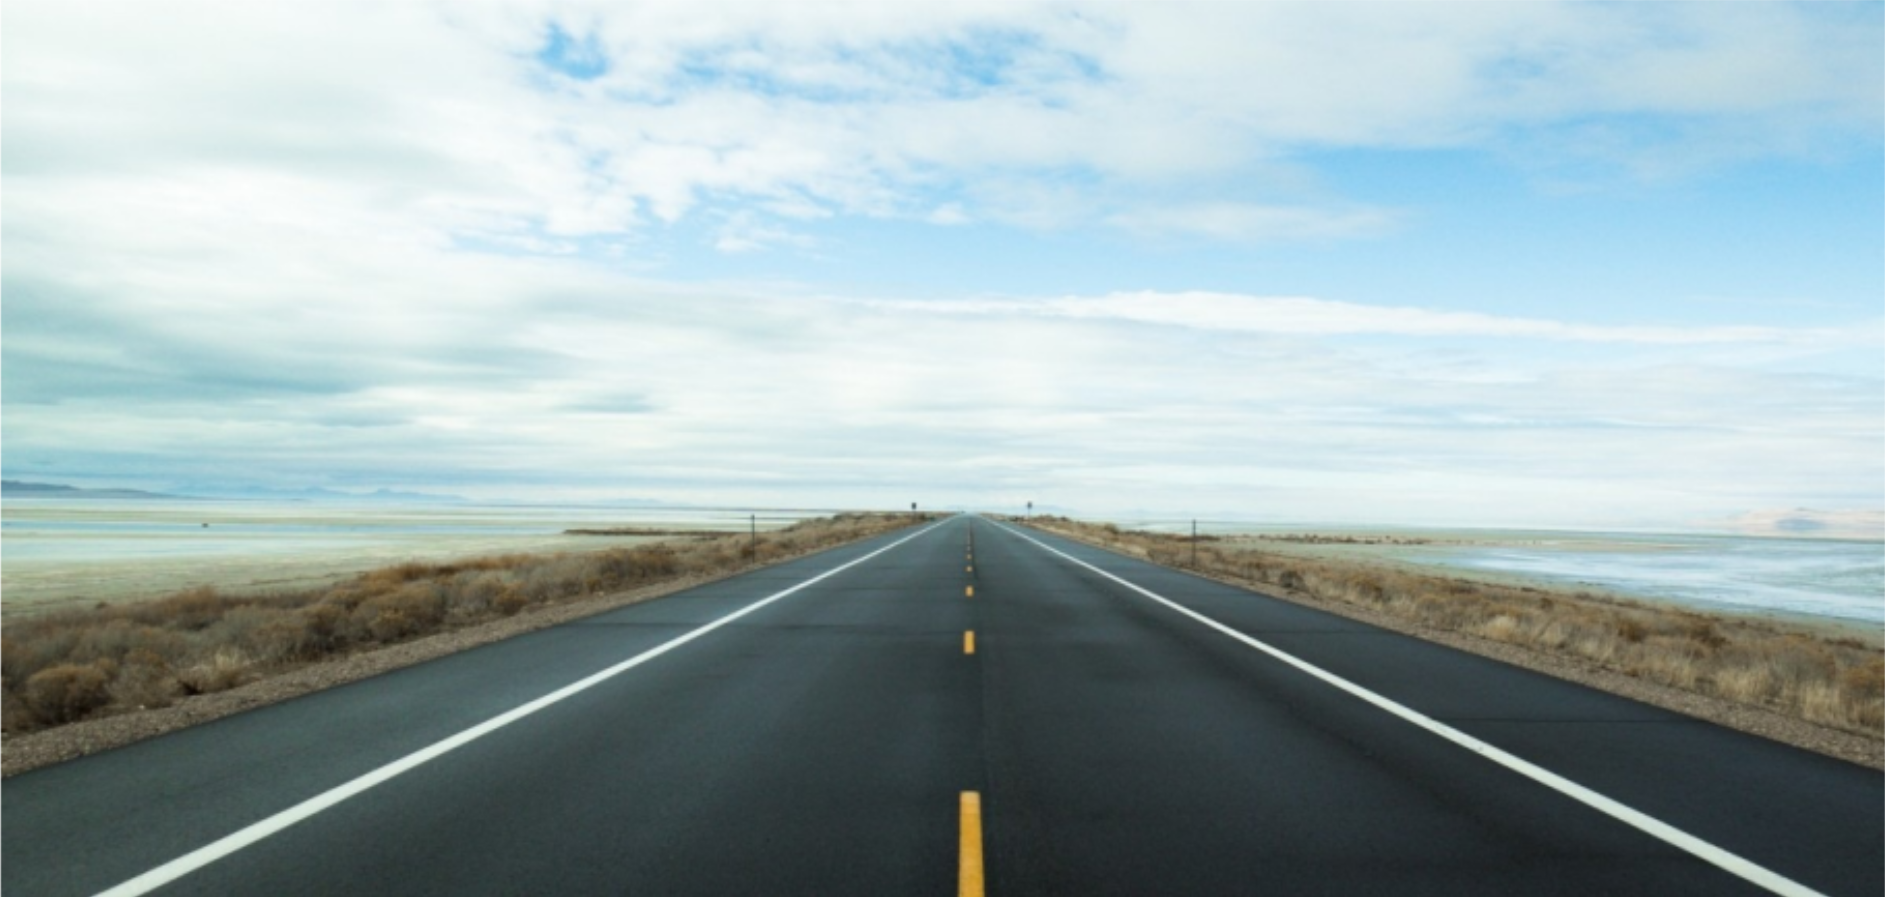

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

img = cv2.imread('/content/Screenshot 2025-03-12 132743.png')
cv2_imshow(img)

The task requires us to filter specific colours from the image. So it would be a good idea to create masks that reveal only specific colors of the image. I took help of this article to do it:  
https://medium.com/featurepreneur/colour-filtering-and-colour-pop-effects-using-opencv-python-3ce7d4576140  
You don't have to read the article. I'll explain everything here.

#Converting the image to HSV colour space
To begin, we will convert image in HSV because HSV provides us continuous colour ranges to filter any colour.

In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#Defining the HSV ranges for white and yellow and then creating respective masks
White can have any hue value as in HSV, white is essentially determined only by value(brightness). For white we need the brightness to be close to 100%(or 255)  
For yellow these values can be verified from the colour wheel. TBH, I just took these values from somewhere on the internet. :)
  
The inRange function is used to create the masks.

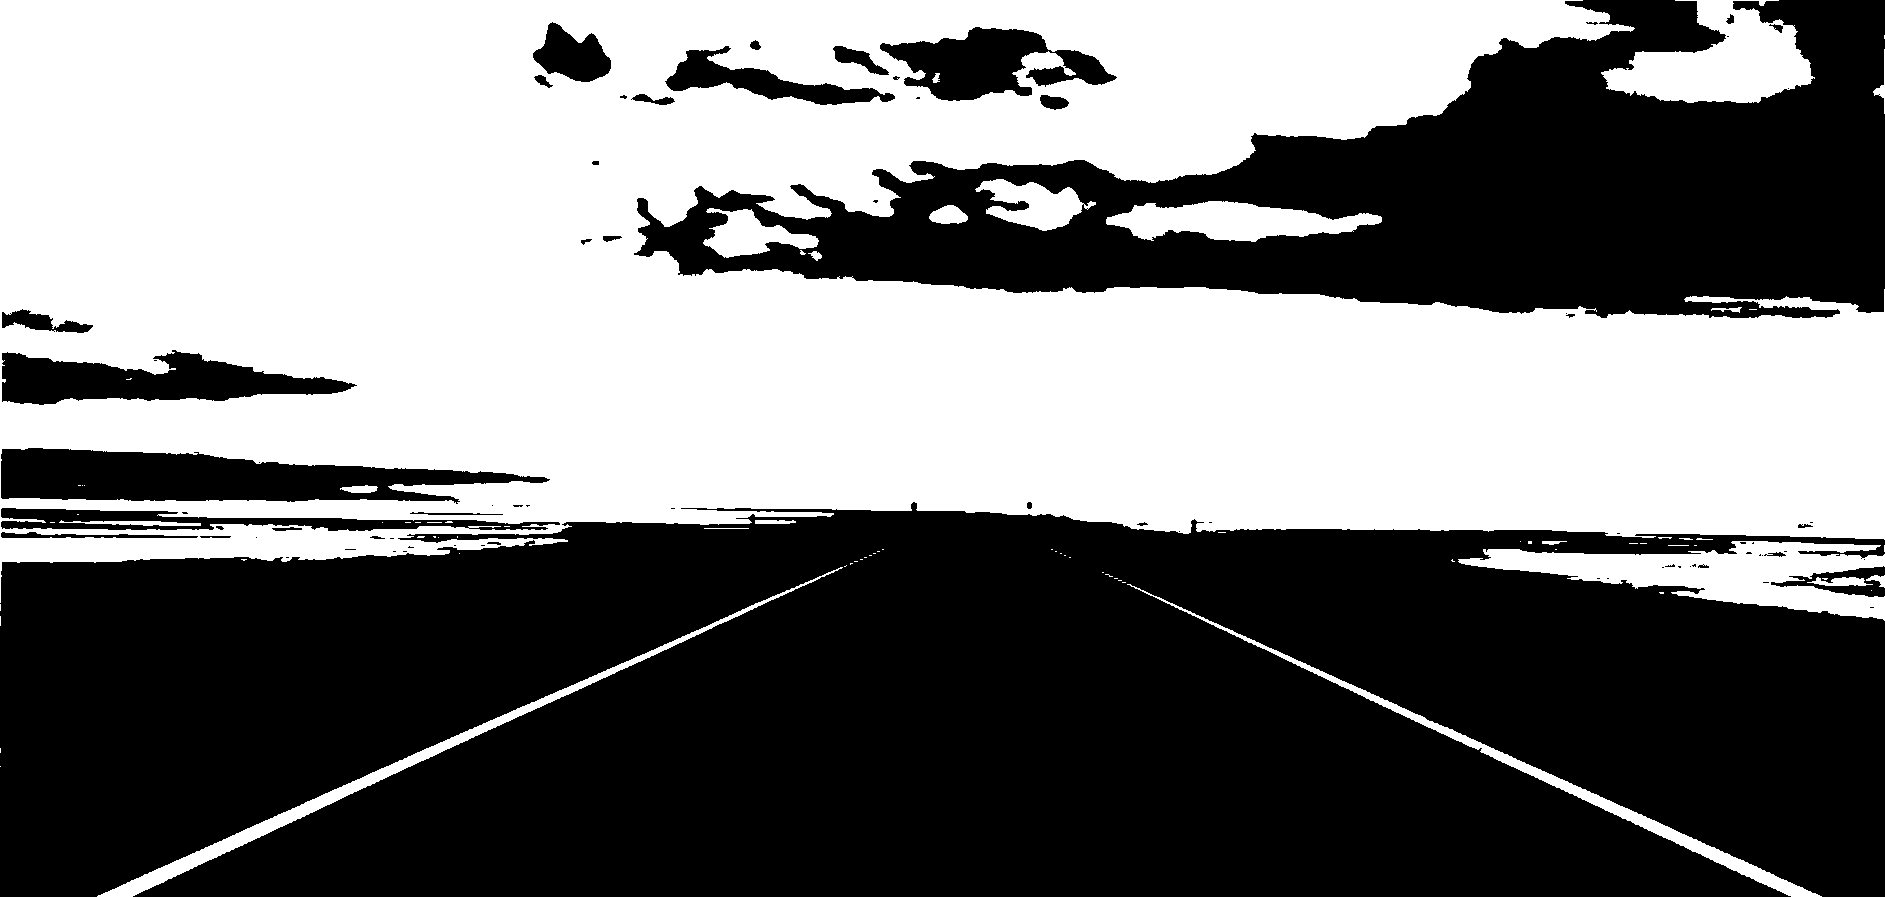

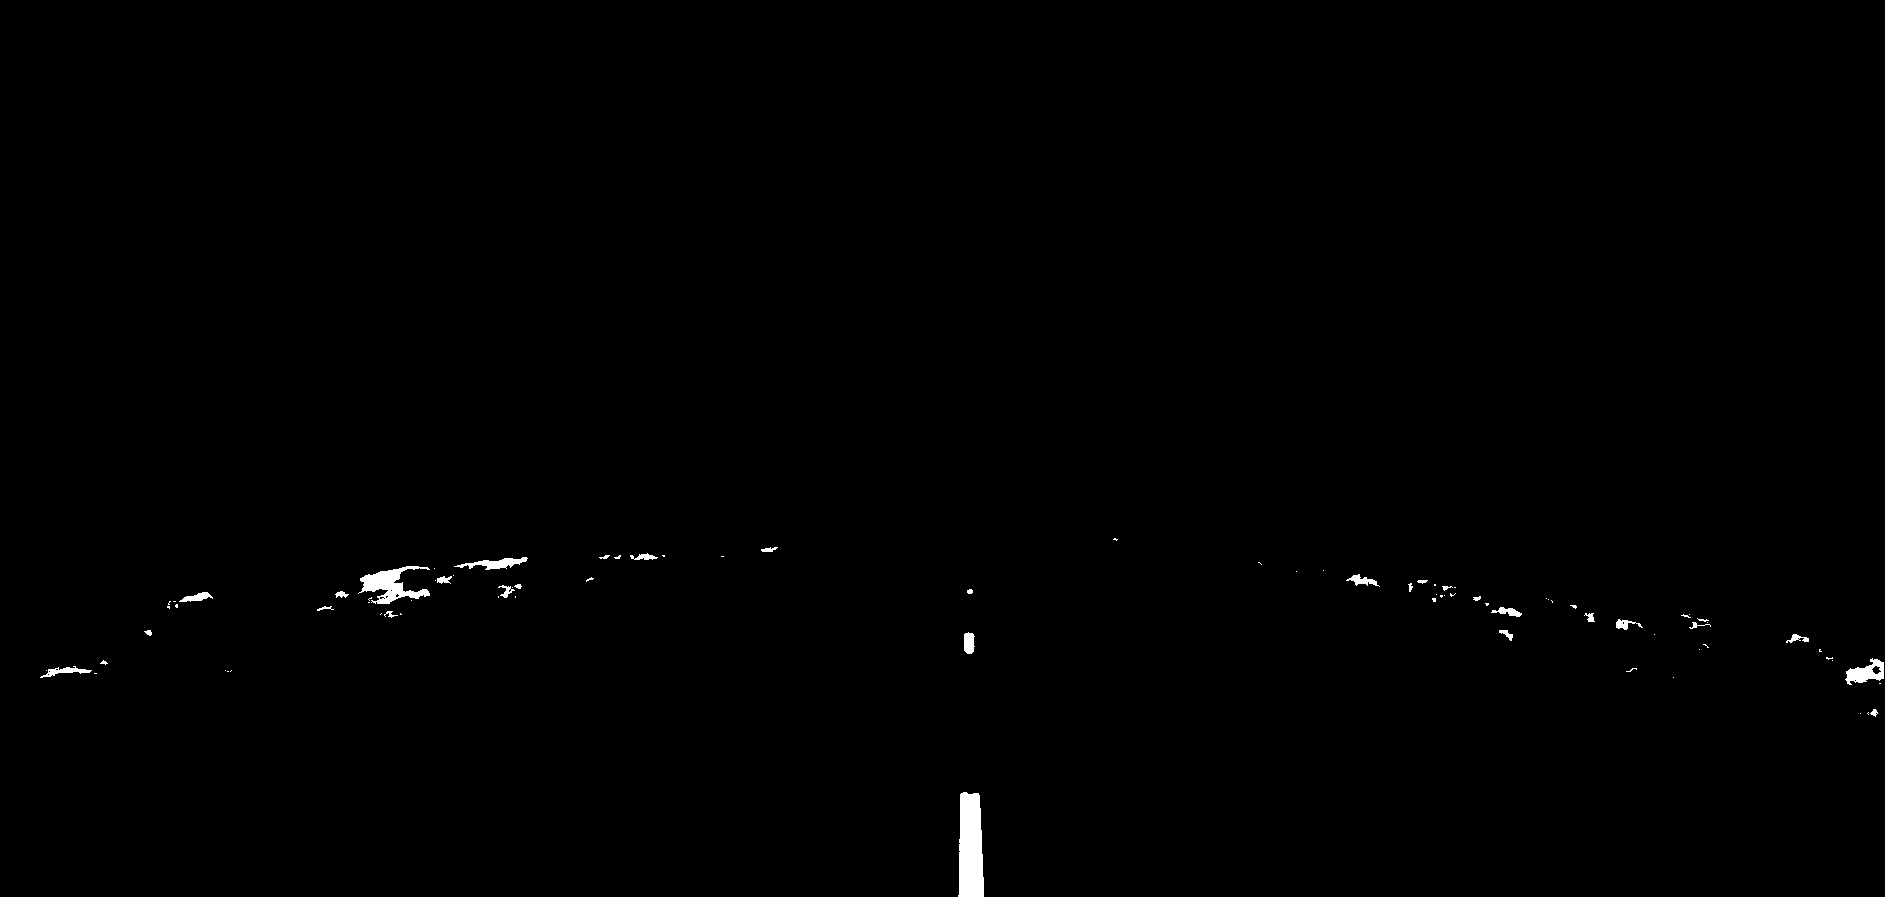

In [ ]:
white_lower = np.array([0, 0, 200], dtype=np.uint8)
white_upper = np.array([180, 50, 255], dtype=np.uint8)

yellow_lower = np.array([0, 100, 100], dtype=np.uint8)
yellow_upper = np.array([40, 255, 255], dtype=np.uint8)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
cv2_imshow(white_mask)
print()
cv2_imshow(yellow_mask)

#Performing edge detection  
I thought it's just a binary image. Not much point of doing usual filtering like gaussian blur, etc. So went straight for edge detection

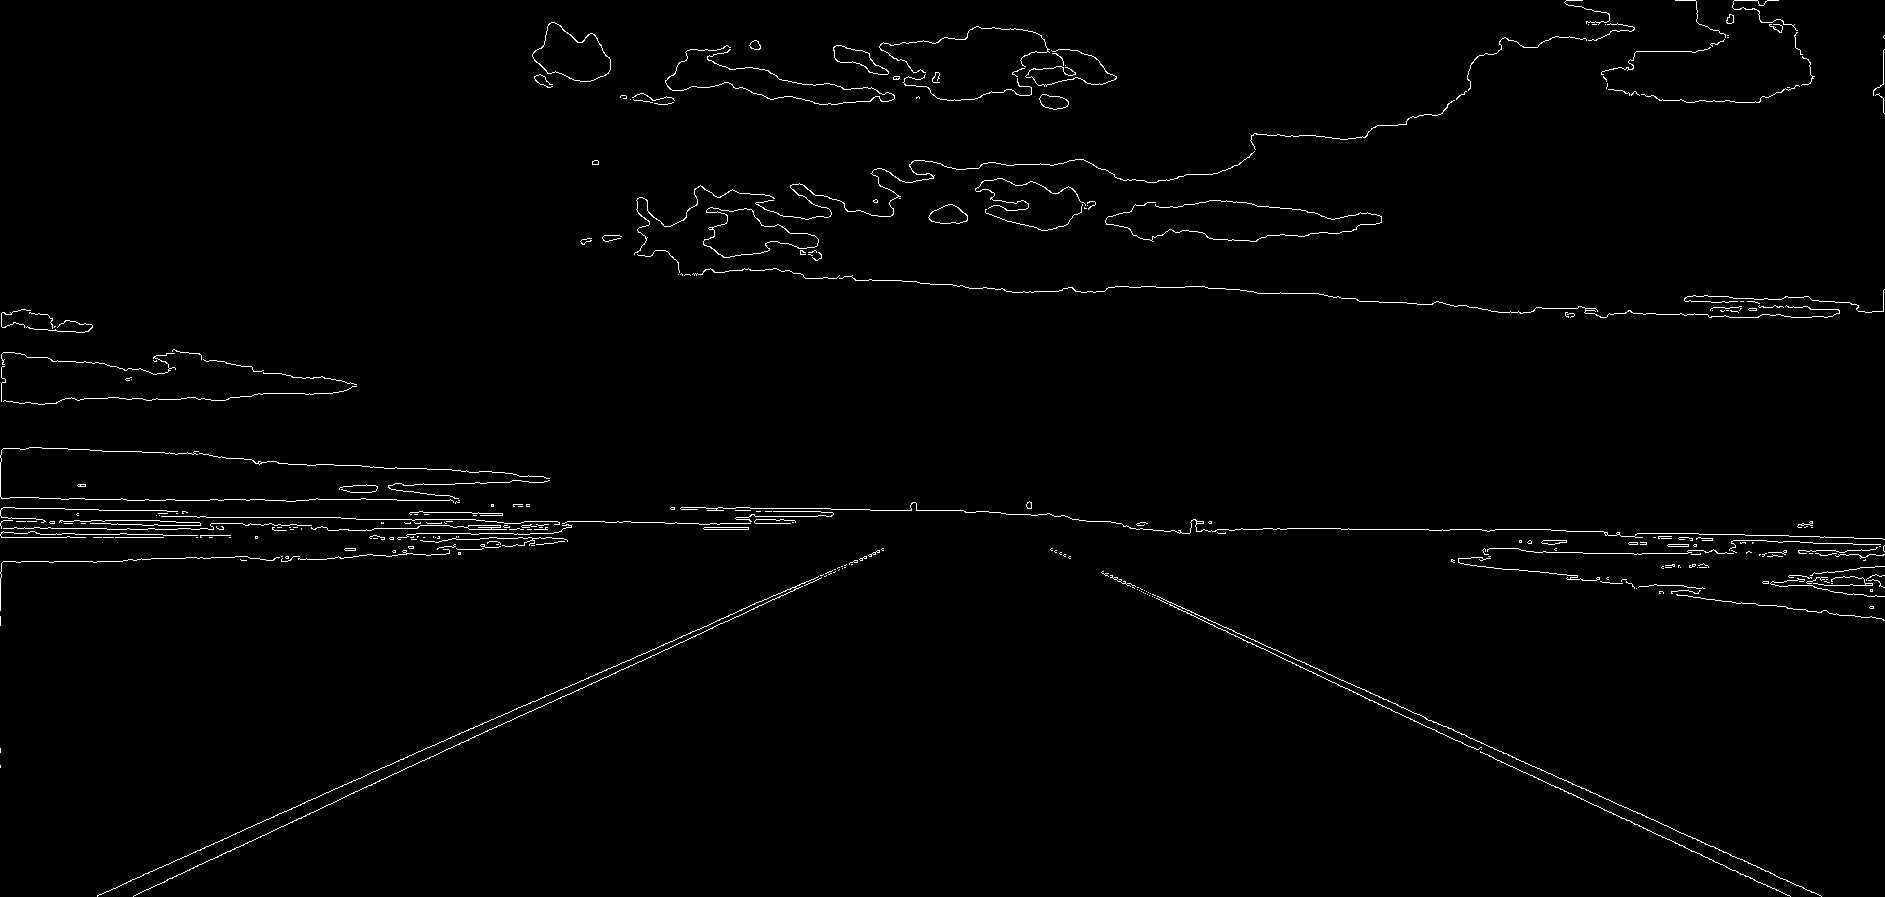

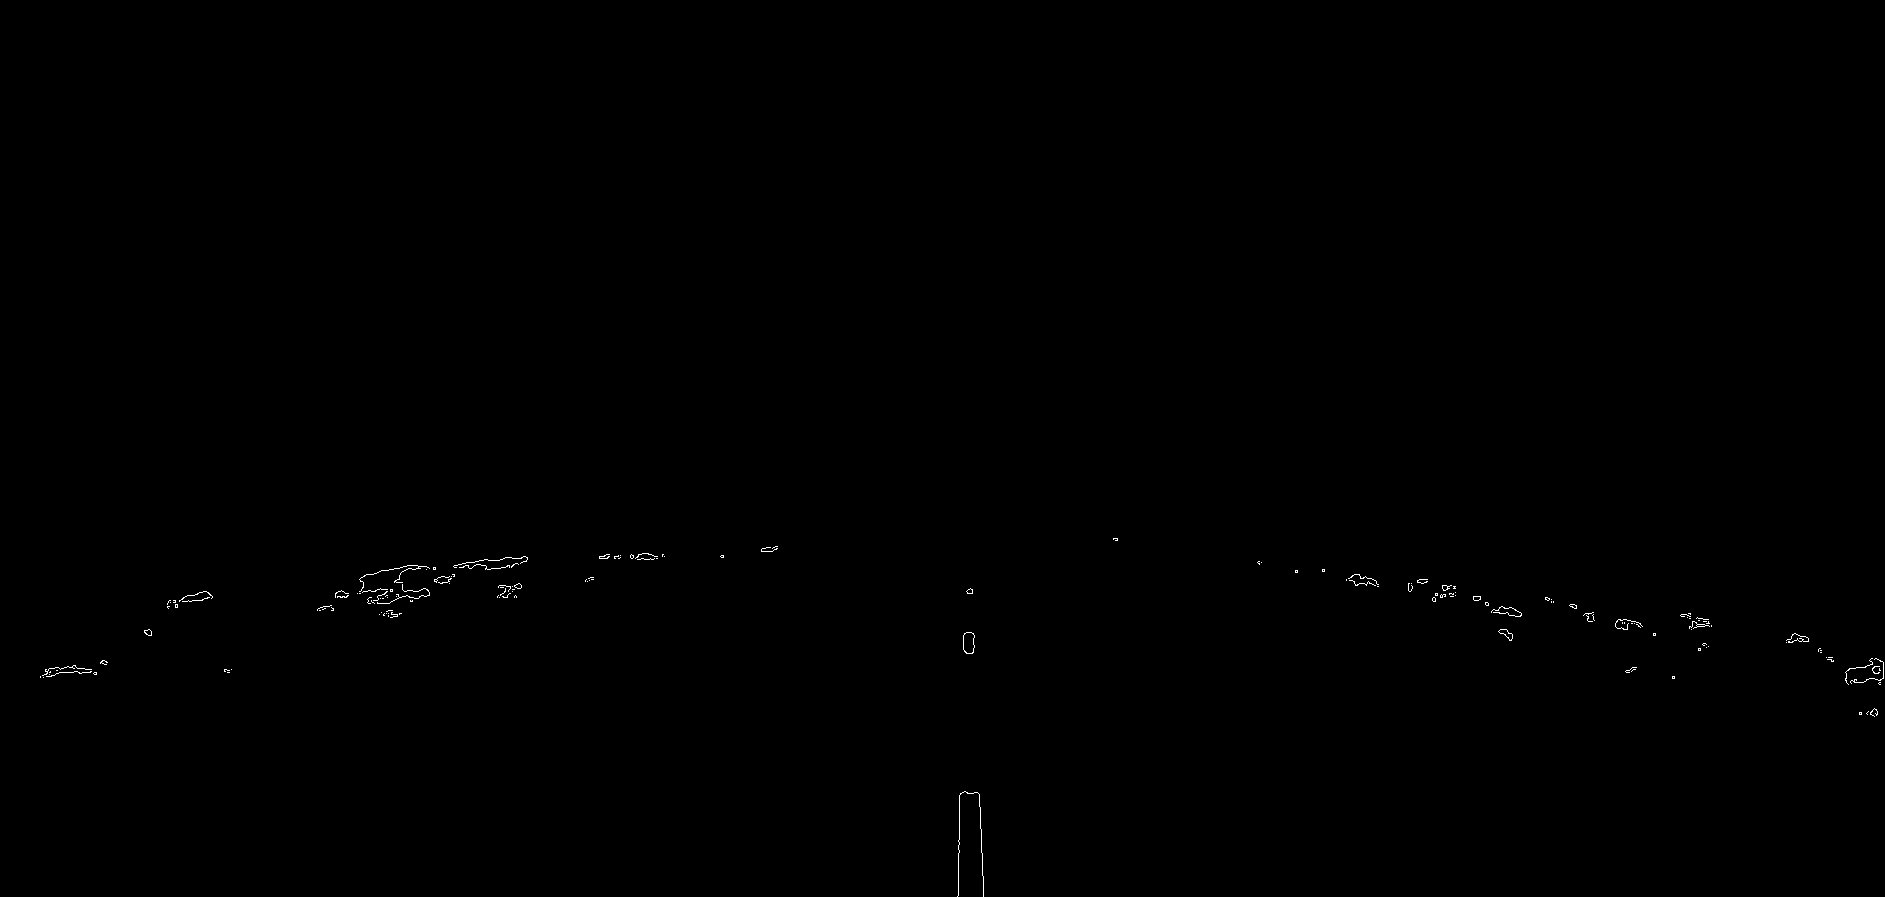

In [ ]:
edges_white = cv2.Canny(white_mask, 50, 150)
edges_yellow = cv2.Canny(yellow_mask, 50, 150)

cv2_imshow(edges_white)
print()
cv2_imshow(edges_yellow)

But clearly there is a lot of noise in this image. So I found about morphological operations from opencv documentation
  
  https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html  
    
So we will do the morphological open operation as we intend to remove the noise from the black region.

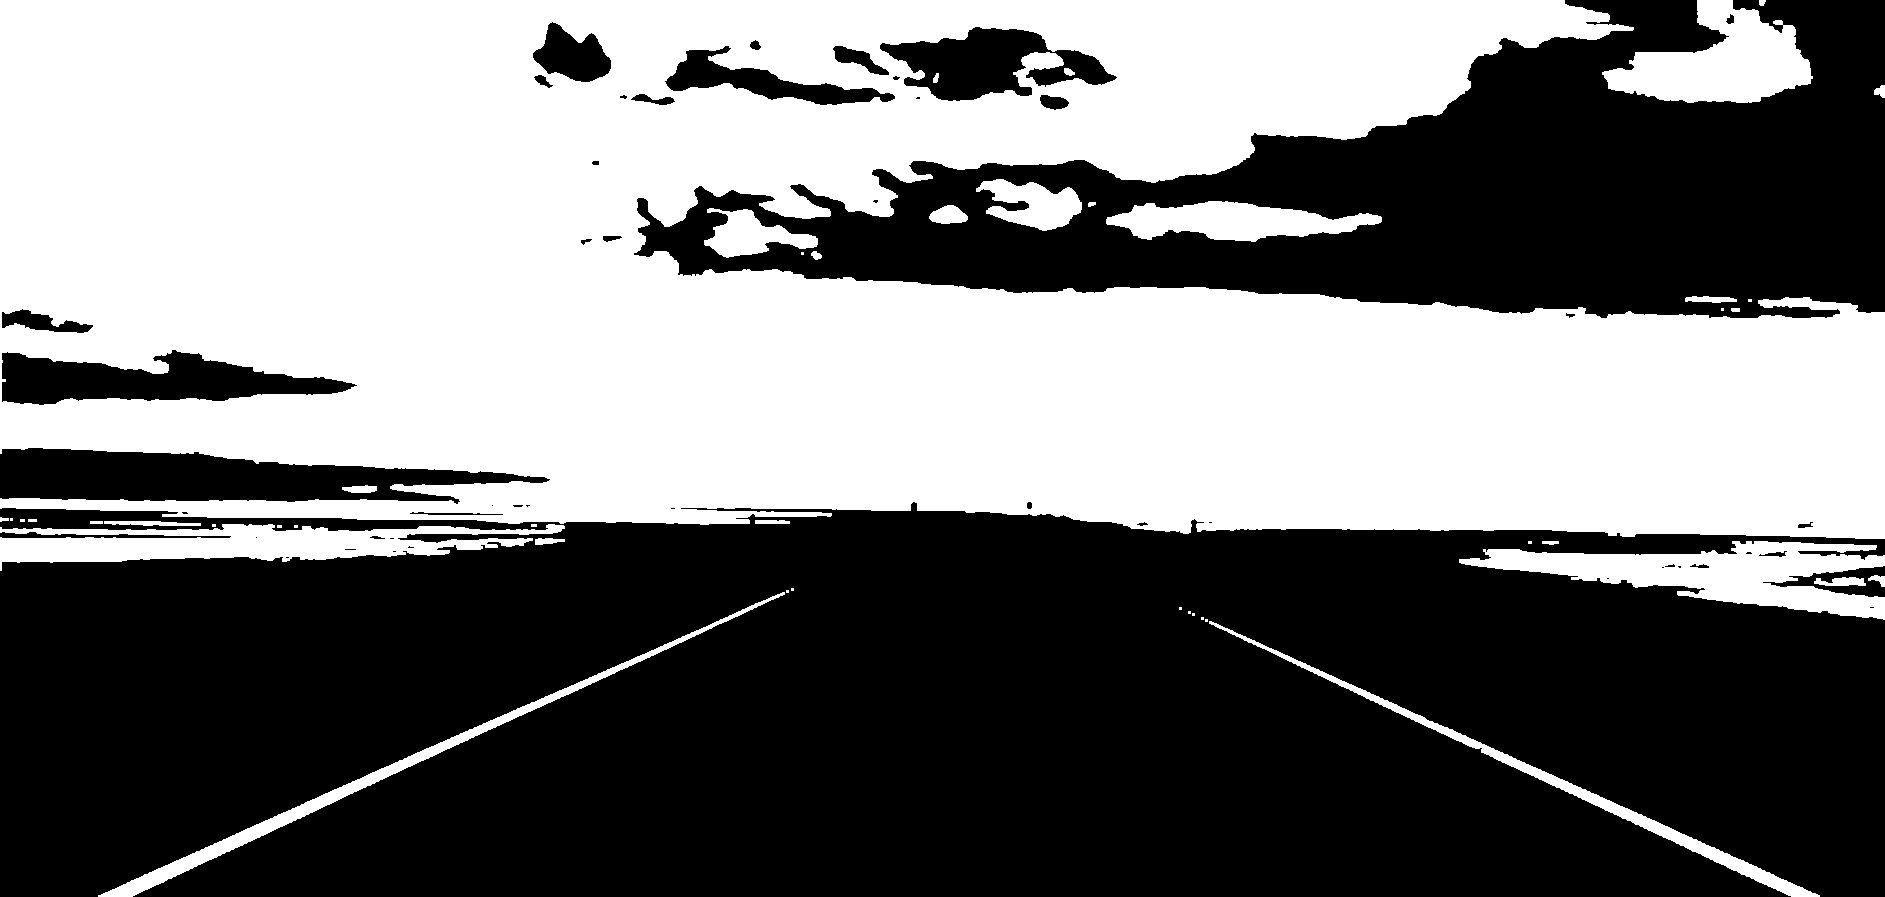

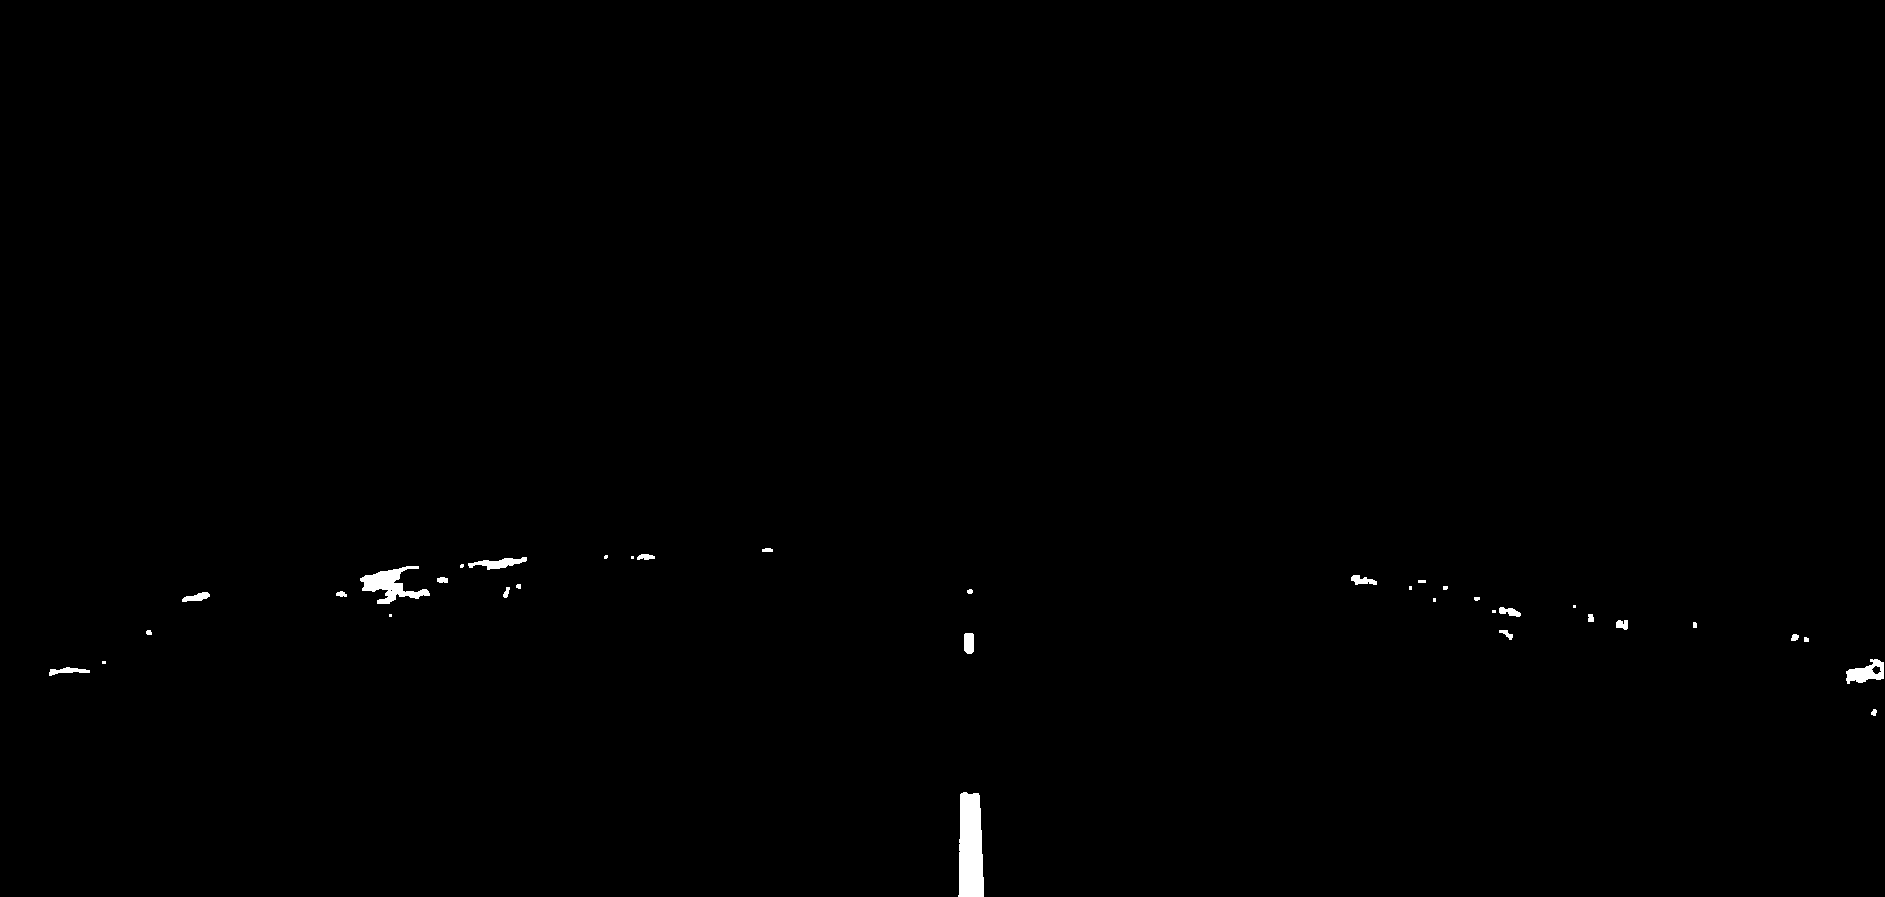

In [ ]:
kernel = np.ones((3, 3), np.uint8)
white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel)
yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)

cv2_imshow(white_mask)
print()
cv2_imshow(yellow_mask)

The image is certainly better. However it seems that we need to cut out a Region of Interest.  
It can probably be done in more sophisticated ways, but I just manually finetuned the coodinates

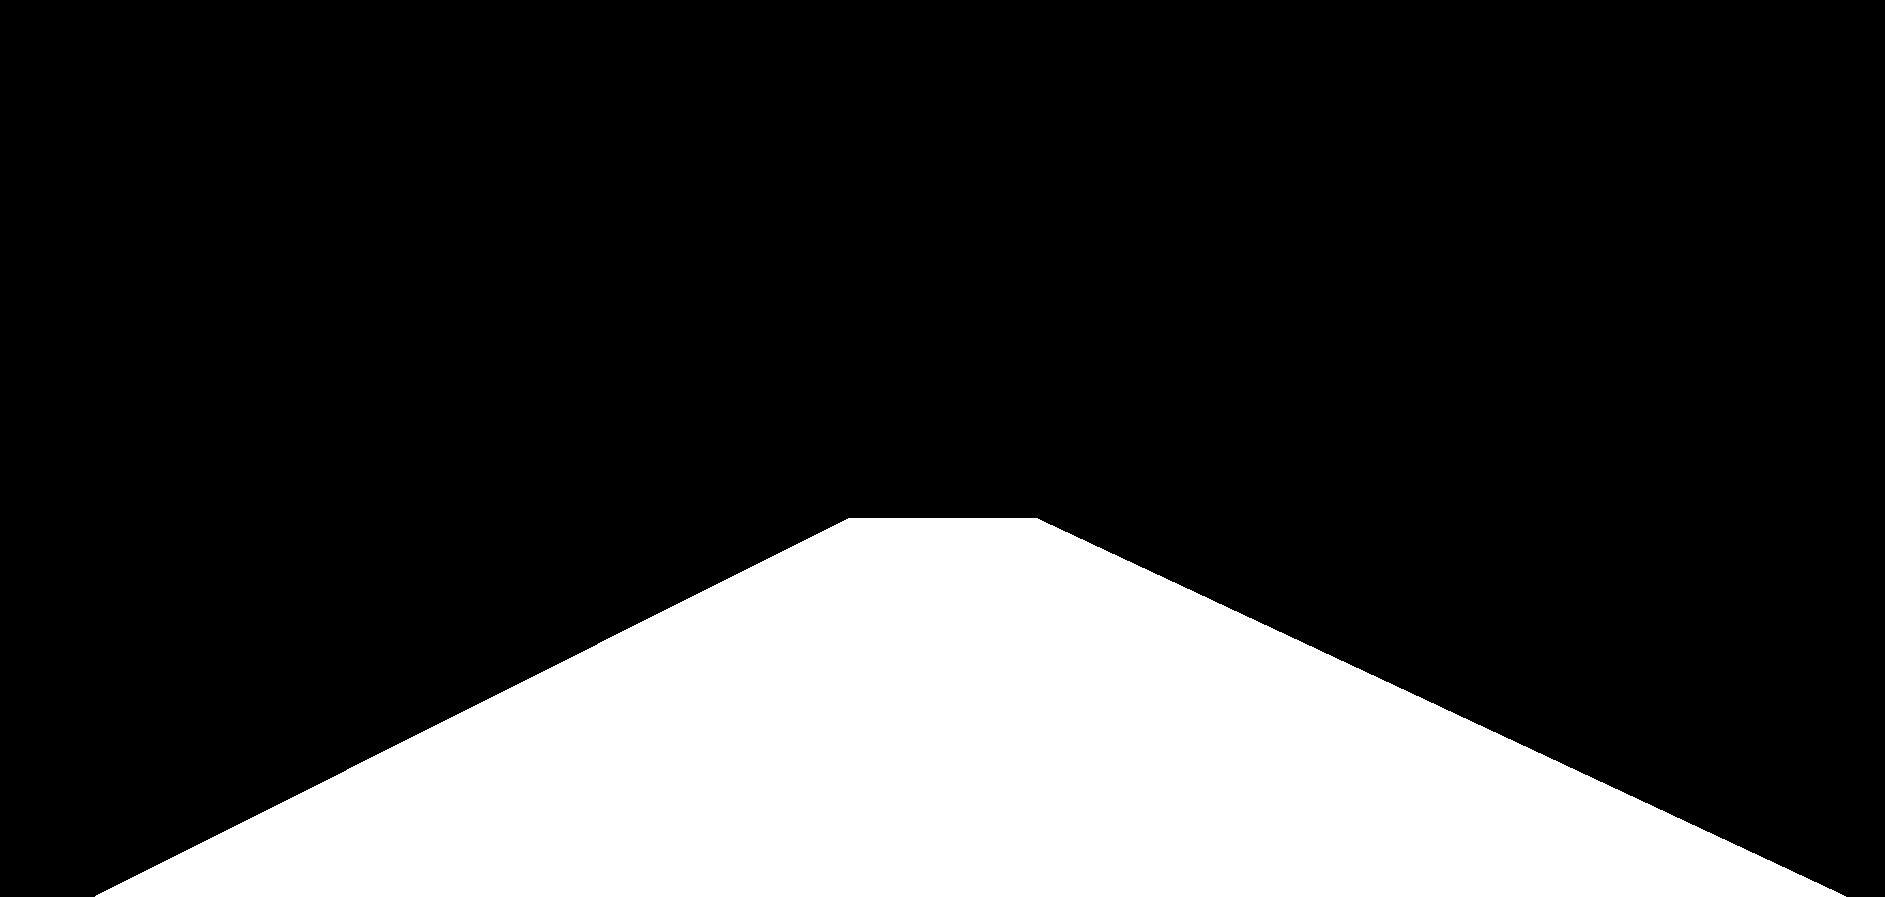

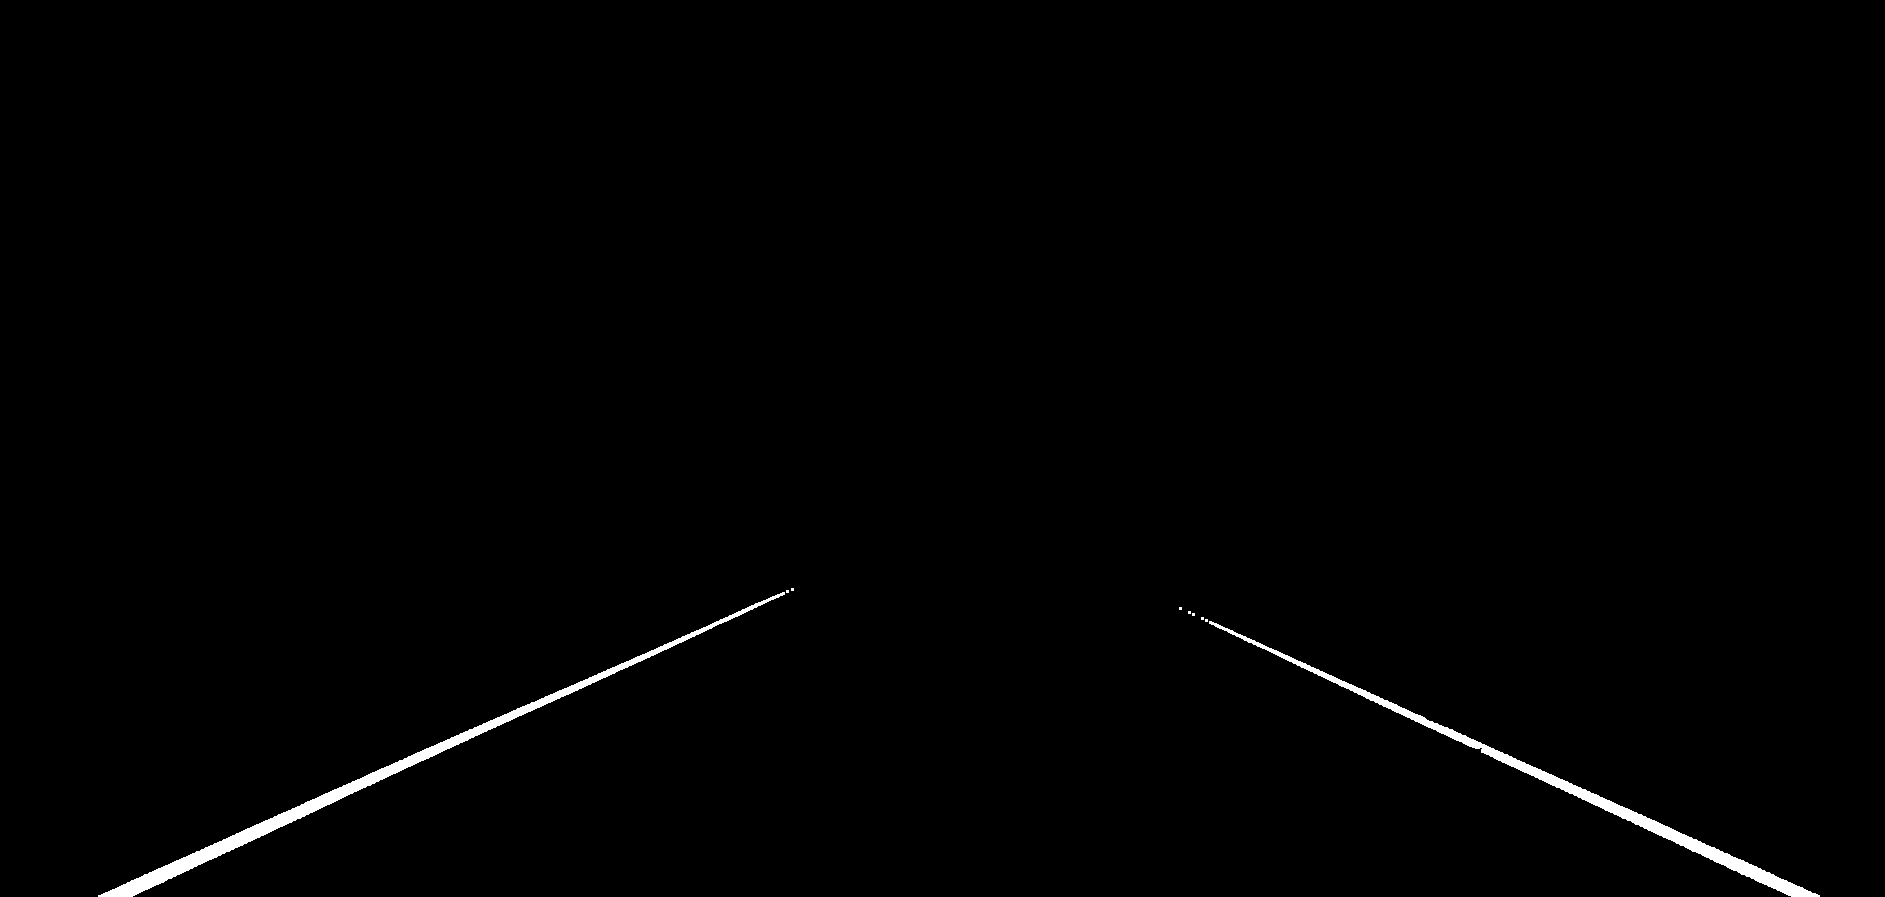

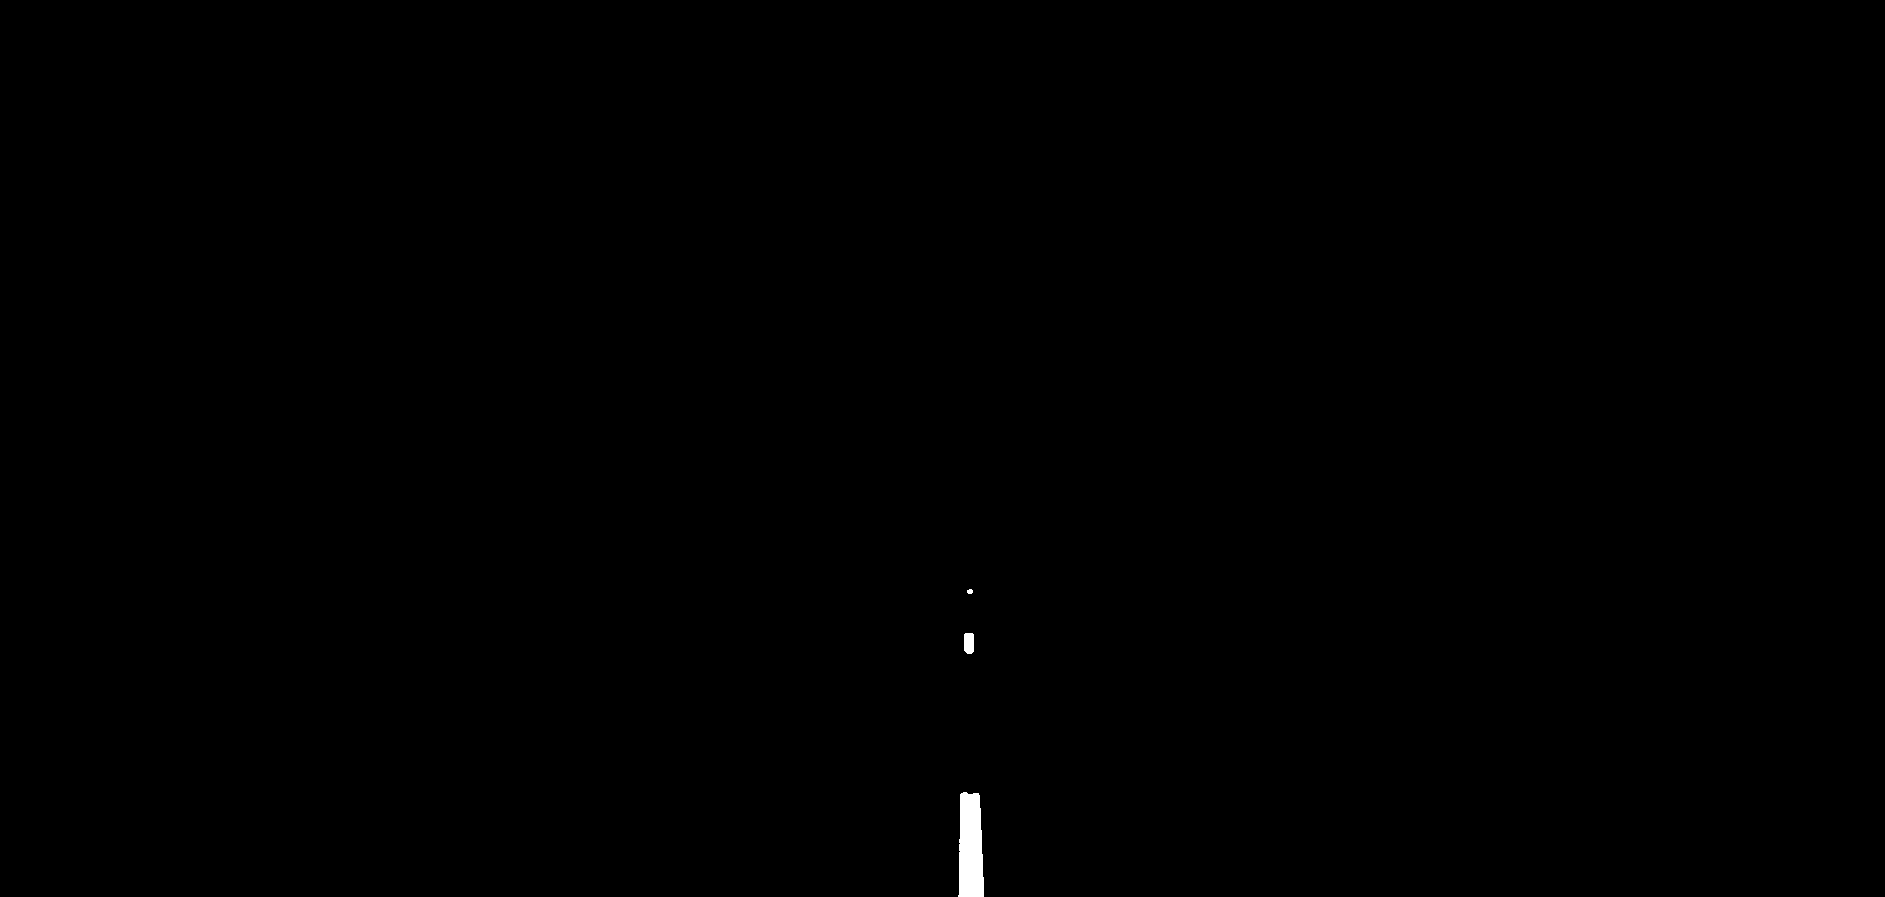

In [ ]:
def roi(image):
  height, width = image.shape
  mask = np.zeros_like(image)
  roi_points = np.array([[
      (int(0.05 * width), height),
      (int(0.45 * width), height//2 + 70),
      (int(0.55 * width), height//2 + 70),
      (int(0.98 * width), height)
  ]], dtype=np.int32)

  cv2.fillPoly(mask, roi_points, 255)

  roi_image = cv2.bitwise_and(image, image, mask=mask)

  return roi_image, mask

white_mask, roi_mask = roi(white_mask)
yellow_mask, roi_mask = roi(yellow_mask)

cv2_imshow(roi_mask)
print()
cv2_imshow(white_mask)
print()
cv2_imshow(yellow_mask)

#Applying the mask on the original image

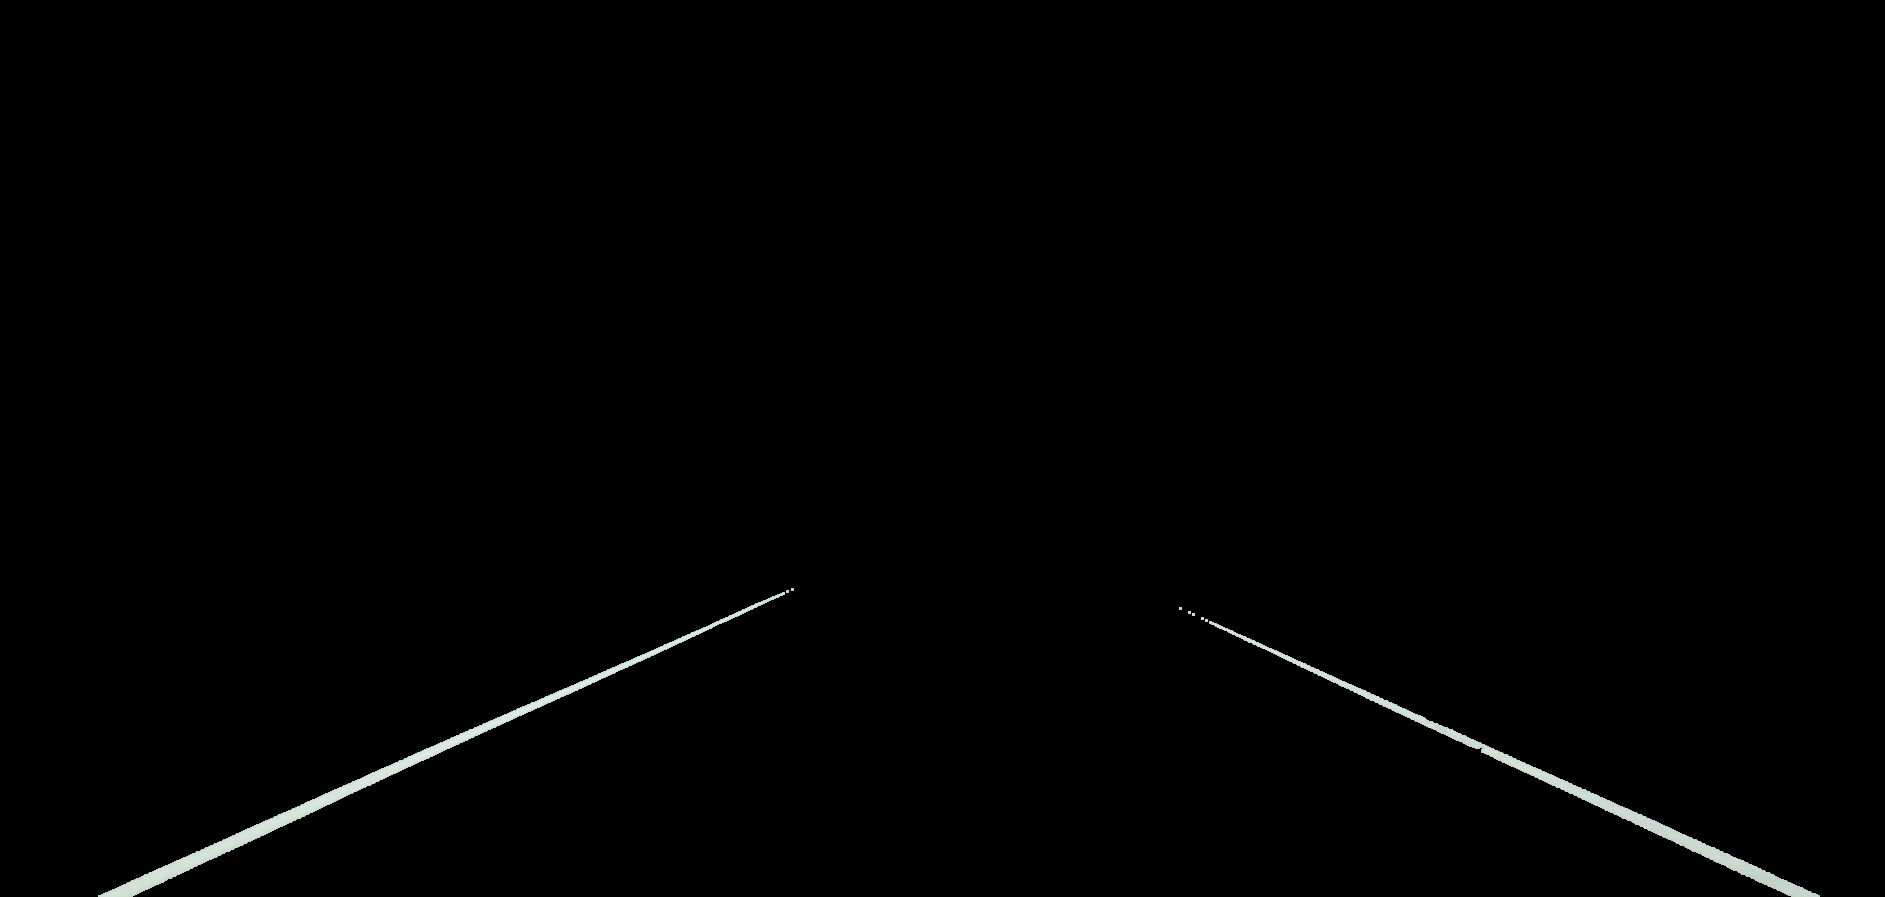

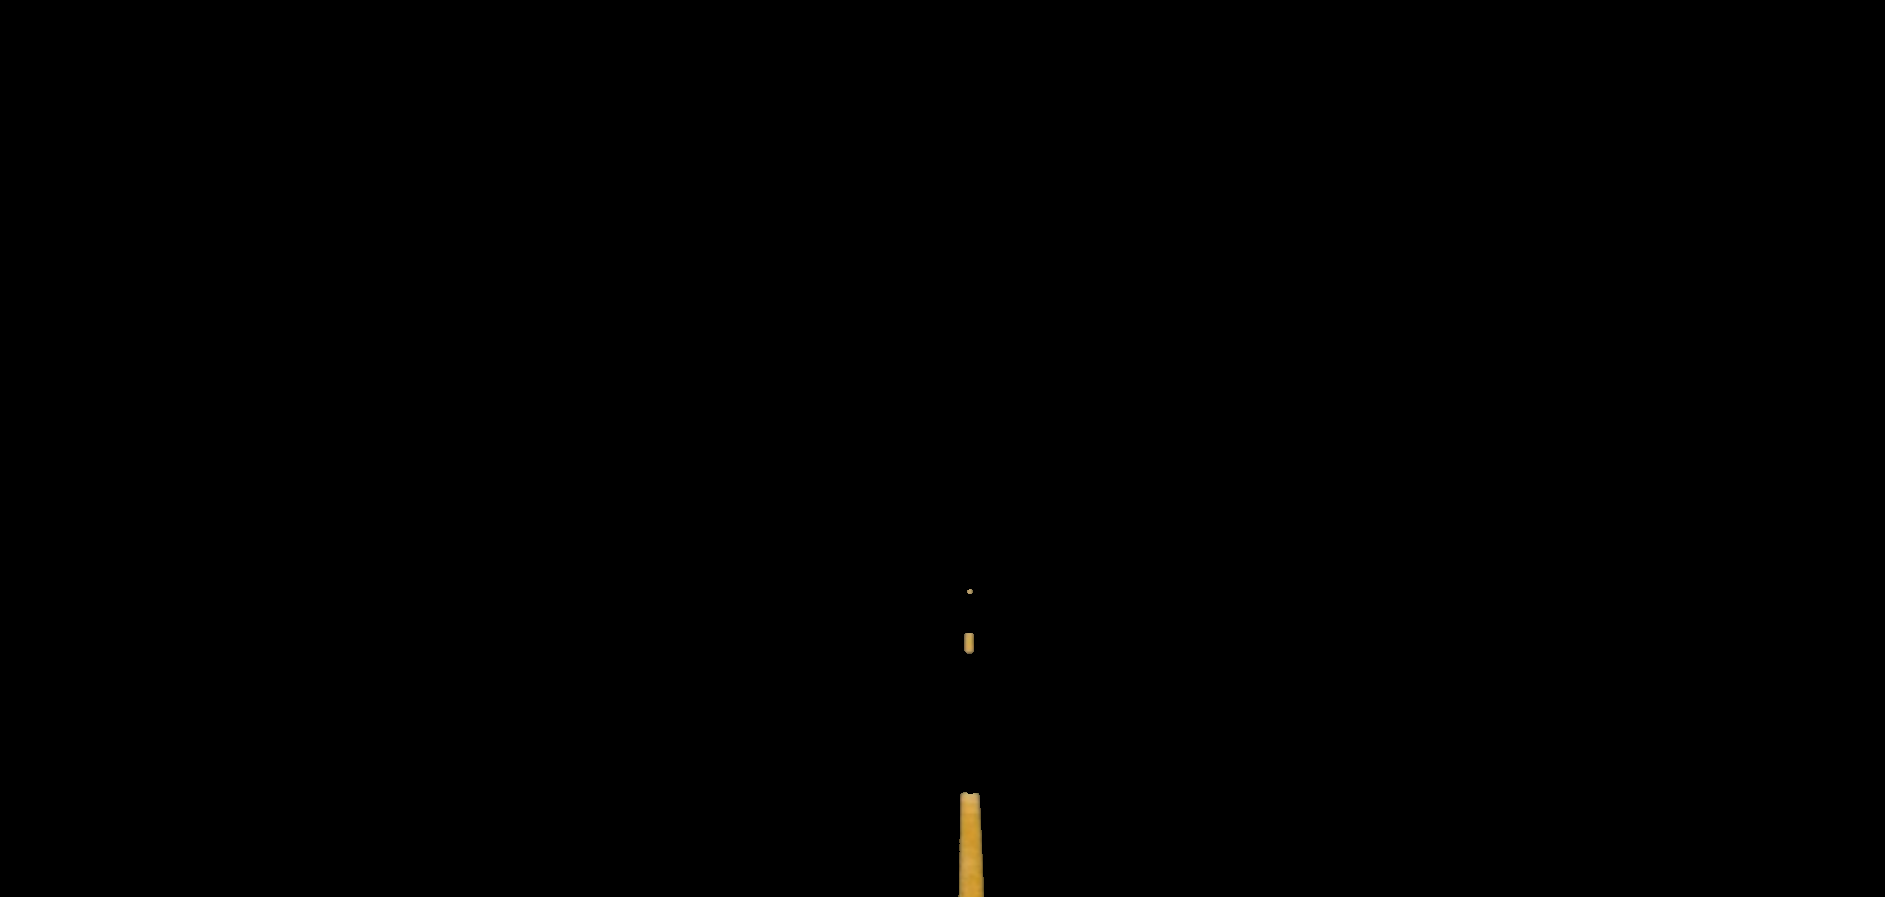

True

In [ ]:
white_lanes = cv2.bitwise_and(img, img, mask=white_mask)
yellow_lanes = cv2.bitwise_and(img, img, mask=yellow_mask)

cv2_imshow(white_lanes)
cv2.imwrite('white_lanes.png', white_lanes)
print()
cv2_imshow(yellow_lanes)
cv2.imwrite('yellow_lanes.png', yellow_lanes)

#Performing canny edge detection

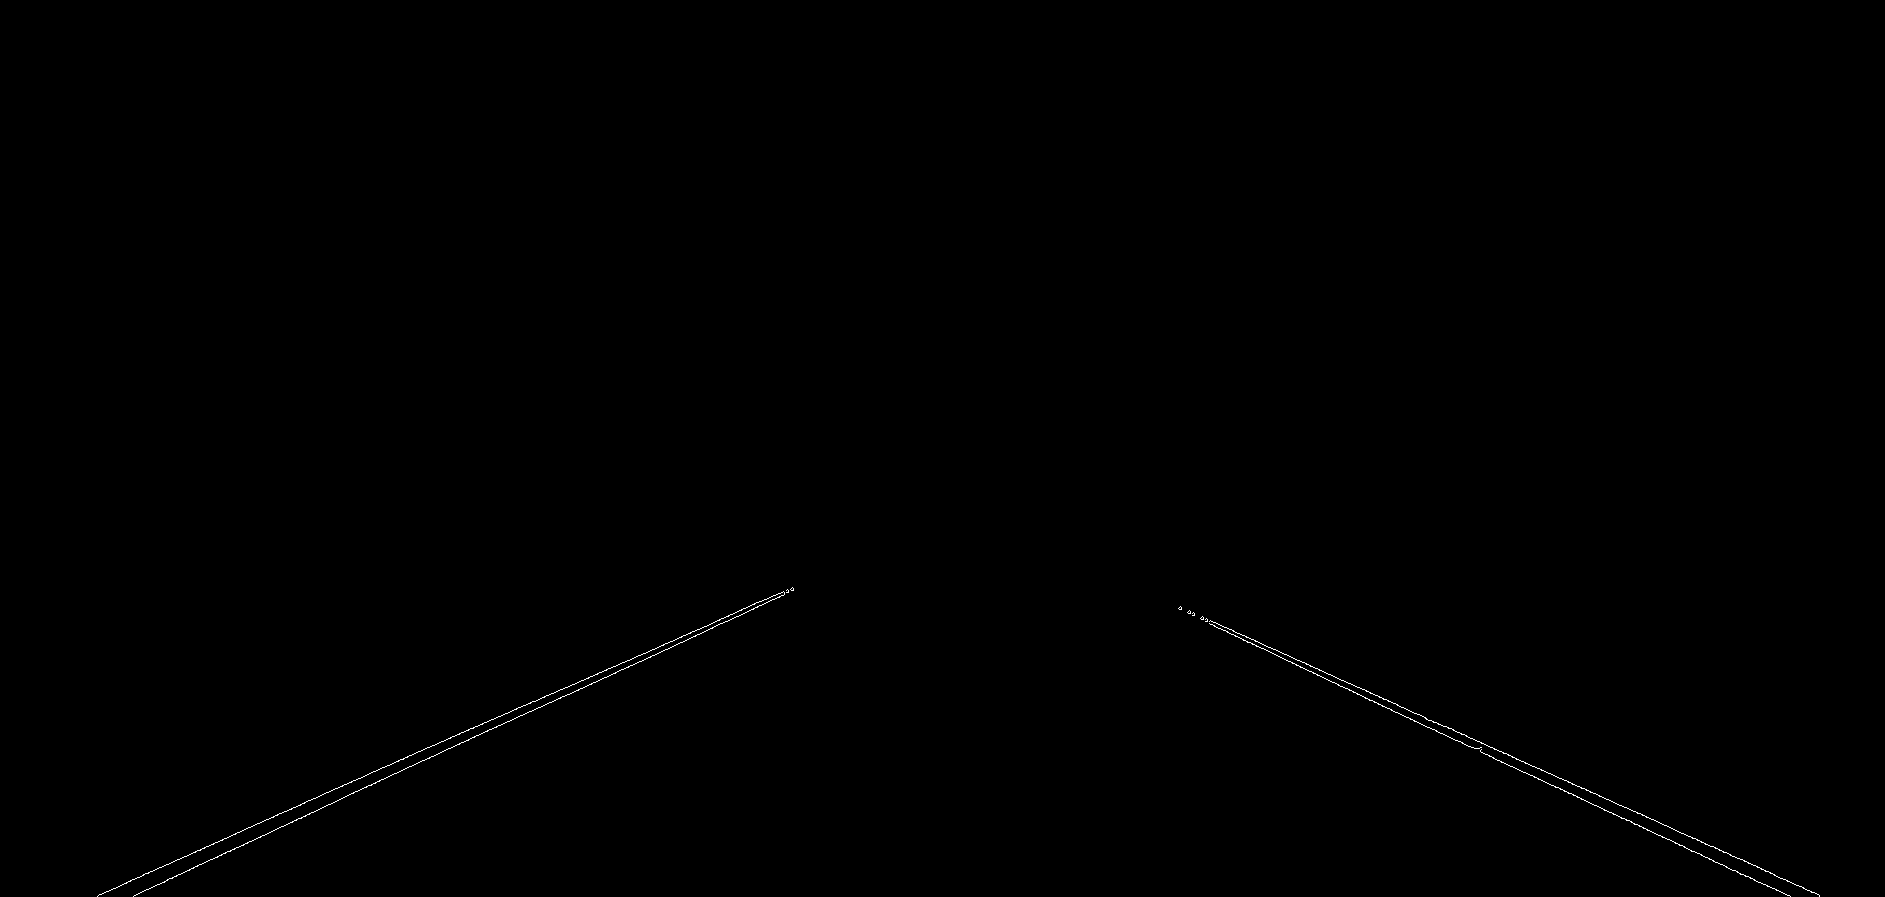

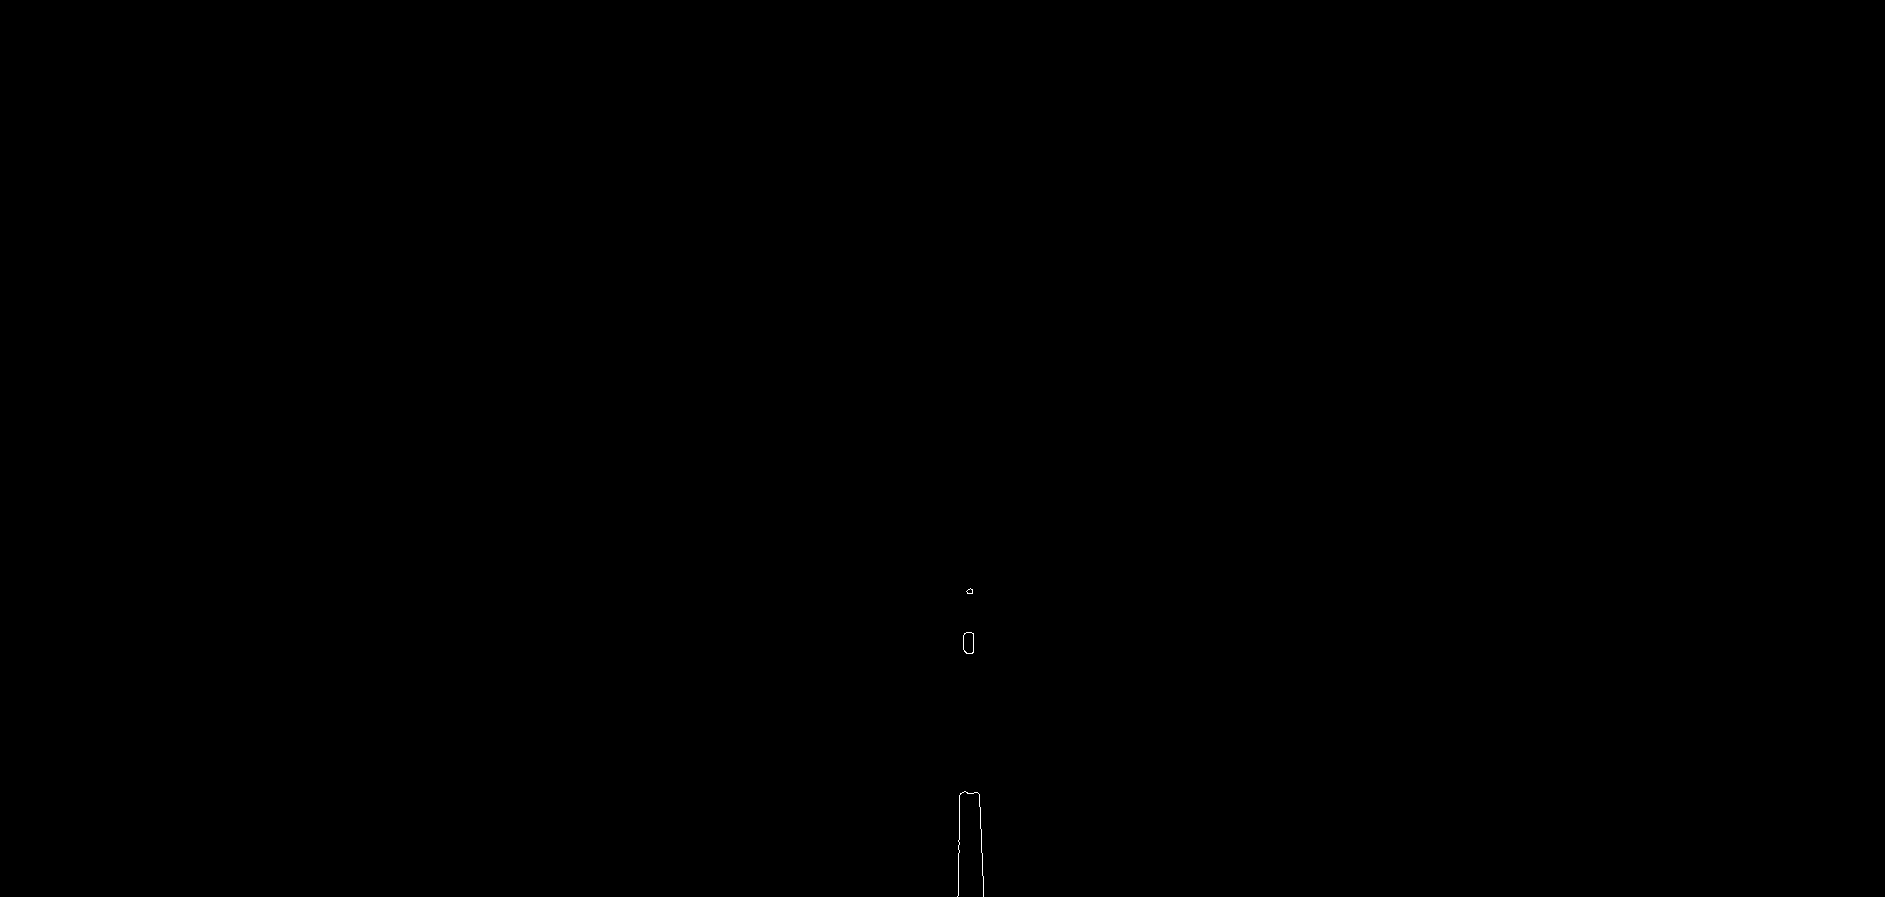

In [ ]:
edges_white = cv2.Canny(white_mask, 50, 150)
edges_yellow = cv2.Canny(yellow_mask, 50, 150)

cv2_imshow(edges_white)
print()
cv2_imshow(edges_yellow)

#Performing Probabilistic Hough Transform on the mask to find the lines

(11, 1, 4)
(5, 1, 4)


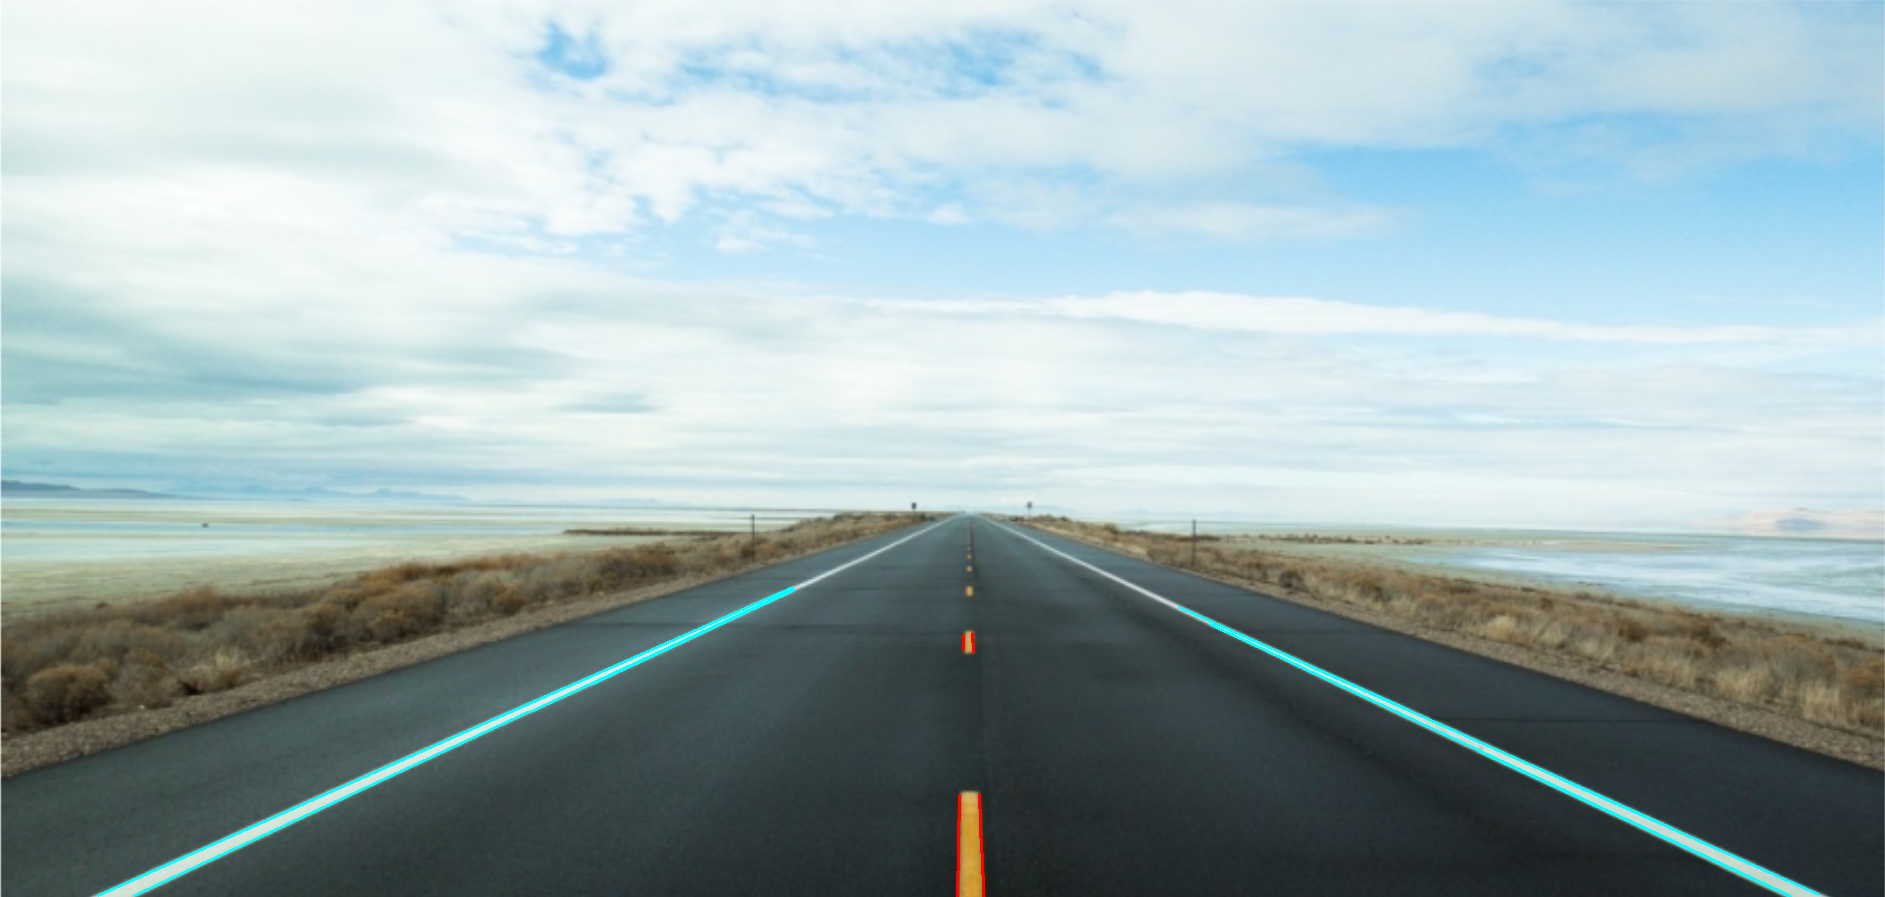

True

In [ ]:
white_lines = cv2.HoughLinesP(edges_white, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)
yellow_lines = cv2.HoughLinesP(edges_yellow, rho=1, theta=np.pi/180, threshold=20, minLineLength=5, maxLineGap=10)

def draw_lines(image, lines, color):
  print(lines.shape)
  if lines is None:
    return
  for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), color, 2)

new_img = img.copy()
draw_lines(new_img, white_lines, (255,255,0))
draw_lines(new_img, yellow_lines, (0,0,255))

cv2_imshow(new_img)
cv2.imwrite('output.png', new_img)